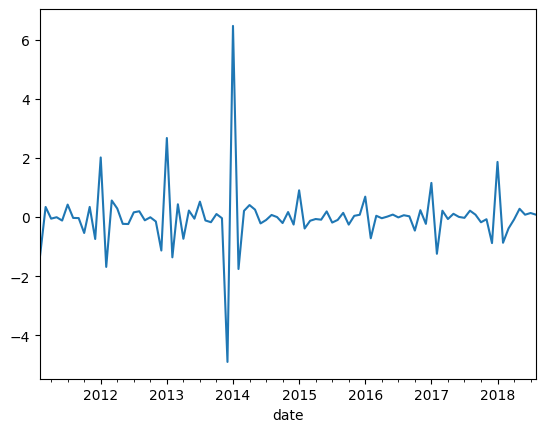

In [65]:
import numpy as np 
import pandas as pd
import warnings
from matplotlib import pyplot as plt 
file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)

# data['sales'].plot()
# raw_data['sales'].plot()

def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

diff_data[0].plot()
diff_data[0].to_excel('./temp.xlsx')

In [7]:
import numpy as np 
import pandas as pd
import warnings
from matplotlib import pyplot as plt 
file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
# data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)

data

,sales
date,
2011-01-01,495.268
2011-02-01,412.960
2011-03-01,654.560
2011-04-01,572.284
2011-05-01,368.036
...,...
2021-06-01,1524.080
2021-07-01,838.668
2021-08-01,777.760


[0]	validation_0-rmse:1.05711	validation_1-rmse:0.19478
[1]	validation_0-rmse:1.00178	validation_1-rmse:0.18701
[2]	validation_0-rmse:0.95041	validation_1-rmse:0.19470
[3]	validation_0-rmse:0.90229	validation_1-rmse:0.19400
[4]	validation_0-rmse:0.85557	validation_1-rmse:0.20499
[5]	validation_0-rmse:0.81171	validation_1-rmse:0.20833
[6]	validation_0-rmse:0.77074	validation_1-rmse:0.21028
[7]	validation_0-rmse:0.73249	validation_1-rmse:0.21254
[8]	validation_0-rmse:0.69637	validation_1-rmse:0.21781
[9]	validation_0-rmse:0.66216	validation_1-rmse:0.21523
[10]	validation_0-rmse:0.62899	validation_1-rmse:0.22068
[11]	validation_0-rmse:0.59789	validation_1-rmse:0.22519
[12]	validation_0-rmse:0.56825	validation_1-rmse:0.23255
[13]	validation_0-rmse:0.53946	validation_1-rmse:0.23452
[14]	validation_0-rmse:0.51248	validation_1-rmse:0.23594
[15]	validation_0-rmse:0.48688	validation_1-rmse:0.23929
[16]	validation_0-rmse:0.46261	validation_1-rmse:0.23985
[17]	validation_0-rmse:0.43984	validation

<AxesSubplot:>

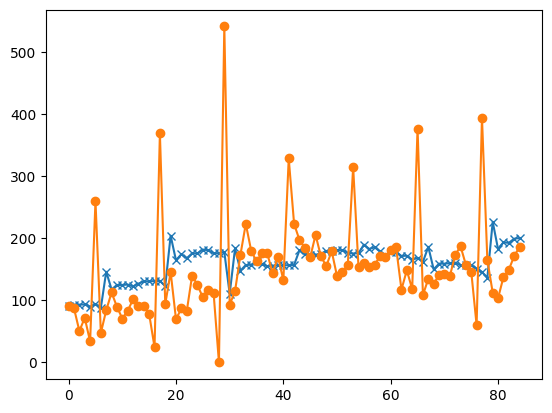

In [17]:
# use xgboost


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import xgboost as xgb

file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


def train_xgboost(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = xgb.XGBRegressor(n_estimators=100,learning_rate=0.1,early_stopping_rounds=50)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    print(test_pred)
    print("xgb r2:",r2_score(y_test,test_pred))
    print("xgb mse:",mean_squared_error(y_test,test_pred))
    print("xgb mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res

def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)


in_window_size,out_window_size = 5,3
input_data = diff_data[0:]
data_predict = train_xgboost(input_data[0],in_window_size,out_window_size,train_num=80)

data_true = input_data[in_window_size+out_window_size-1:]


inverse_predict =  inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0],data_predict)
inverse_predict = inverse_predict.apply(np.expm1)

inverse_true  = inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0],data_true[0])
inverse_true = inverse_true.apply(np.expm1)

print("raw r2:",r2_score(inverse_true[0],inverse_predict[0]))
print("raw mse:",mean_squared_error(inverse_true[0],inverse_predict[0]))
print("raw mae:",mean_absolute_error(inverse_true[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_true[0].plot(marker='o')





21:57:53 - cmdstanpy - INFO - Chain [1] start processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing


-0.9127330130708264
24460.410529331202
123.24289434485658


<AxesSubplot:>

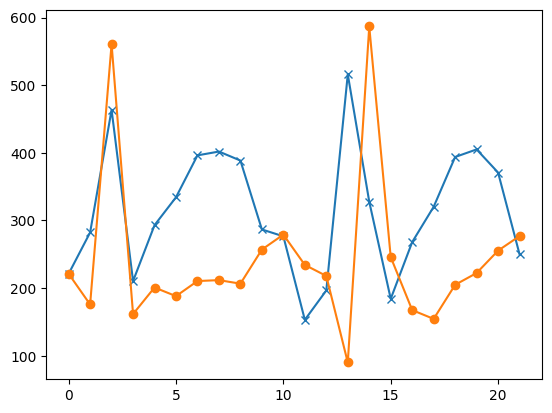

In [20]:
## train Prophet 


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

# diff_data[0].plot()

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

train_num = 70
# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data,test_data = diff_data[:train_num],diff_data[train_num:]

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']

train_data['ds'] = train_data.index
train_data = train_data[['ds','y']]

model = Prophet()
model.fit(train_data[0:])
future_times = model.make_future_dataframe(test_data.shape[0],freq='M',include_history=False)

test_predict = model.predict(future_times).yhat

# test_predict.index = test_data.index
# # test_predict = scaler.inverse_transform(test_predict).reshape(-1)
# # test_data = scaler.inverse_transform(test_data).reshape(-1)
# # train_data = scaler.inverse_transform(train_data)
# # test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)
inverse_predict = inverse_predict.apply(np.expm1)
# # # # inverse_predict



inverse_test = inverse_difference(train_data.y.sum()+data['sales'][0],test_data.y)
inverse_test = inverse_test.apply(np.expm1)



print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))
print(mean_absolute_error(inverse_test[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_test[0].plot(marker='o')


-1.6646832628991706
33651167373050.52
4108171.3137968625


<AxesSubplot:>

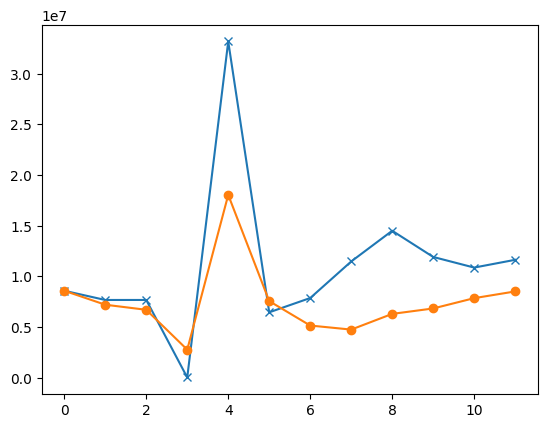

In [23]:
#arima
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]



def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

train_num = 80
# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data,test_data = diff_data[:train_num],diff_data[train_num:]

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']



start_num = 0

model = auto_arima(train_data[start_num:], seasonal=True, m=24)
test_predict = model.predict(test_data.shape[0])

test_predict.index = test_data.index

# test_predict = scaler.inverse_transform(test_predict).reshape(-1)

# test_data = scaler.inverse_transform(test_data).reshape(-1)
# train_data = scaler.inverse_transform(train_data)
# test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)

inverse_predict = inverse_predict.apply(np.expm1)
# # # inverse_predict



inverse_test = inverse_difference(train_data.y.sum()+data['sales'][0],test_data.y)
inverse_test = inverse_test.apply(np.expm1)



print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))
print(mean_absolute_error(inverse_test[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_test[0].plot(marker='o')

In [38]:
# test
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]

data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled


# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data = diff_data

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:-1]
train_data.columns =['y']





model = auto_arima(train_data[0:], seasonal=True, m=12)
test_predict = model.predict(70)



# test_predict = scaler.inverse_transform(test_predict).reshape(-1)

# test_data = scaler.inverse_transform(test_data).reshape(-1)
# train_data = scaler.inverse_transform(train_data)
# test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)

inverse_predict = inverse_predict.apply(np.expm1)
# print("train_end_date date:%s"%train_data.index[-1])
# print(inverse_predict)
datetime_series = pd.Series(pd.date_range(train_data.index[-1], periods=71, freq="m"))
inverse_predict['date'] = datetime_series
print(inverse_predict)

             0       date
0   276.900000 2018-07-31
1   257.048749 2018-08-31
2   219.595729 2018-09-30
3   232.600364 2018-10-31
4    99.818038 2018-11-30
..         ...        ...
66  371.405238 2024-01-31
67  408.719225 2024-02-29
68  396.633586 2024-03-31
69  422.726533 2024-04-30
70  418.360079 2024-05-31

[71 rows x 2 columns]


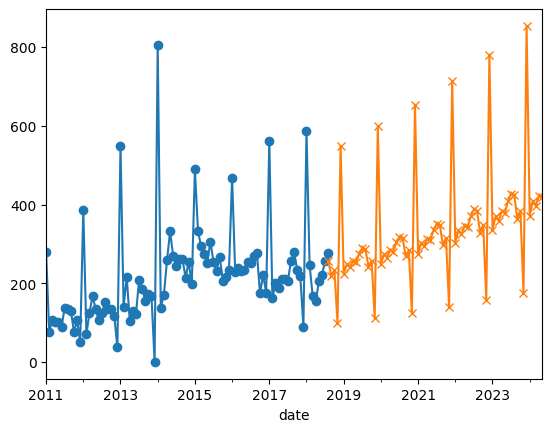

In [39]:
file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data.set_index(raw_data['date'],inplace=True)
raw_data['sales'][:-13].plot(marker='o')

inverse_predict.set_index(inverse_predict['date'],inplace=True)
# ma = inverse_predict[0].max()
# mi = inverse_predict[0].min()
# nmi = 120000
# nma = 1.5e7
# ((inverse_predict[0]-mi)/(ma-mi)*(nma-nmi)+nmi)[1:].plot(marker='x')
# ((inverse_predict[0]-mi)/(ma-mi)*(nma-nmi)+nmi)[1:].to_excel('./temp.xlsx')

(inverse_predict[0])[1:].plot(marker='x')
# ((inverse_predict[0]-mi)/(ma-mi)*(nma-nmi)+nmi)[1:].to_excel('./temp.xlsx')
(inverse_predict[0]).to_excel('./temp.xlsx')

epoch_0:tensor(0.2999, grad_fn=<MseLossBackward0>)
epoch_1:tensor(0.2389, grad_fn=<MseLossBackward0>)
epoch_2:tensor(0.2283, grad_fn=<MseLossBackward0>)
epoch_3:tensor(0.2377, grad_fn=<MseLossBackward0>)
epoch_4:tensor(0.2390, grad_fn=<MseLossBackward0>)
epoch_5:tensor(0.2355, grad_fn=<MseLossBackward0>)
epoch_6:tensor(0.2306, grad_fn=<MseLossBackward0>)
epoch_7:tensor(0.2267, grad_fn=<MseLossBackward0>)
epoch_8:tensor(0.2251, grad_fn=<MseLossBackward0>)
epoch_9:tensor(0.2253, grad_fn=<MseLossBackward0>)
epoch_10:tensor(0.2255, grad_fn=<MseLossBackward0>)
epoch_11:tensor(0.2258, grad_fn=<MseLossBackward0>)
epoch_12:tensor(0.2252, grad_fn=<MseLossBackward0>)
epoch_13:tensor(0.2248, grad_fn=<MseLossBackward0>)
epoch_14:tensor(0.2248, grad_fn=<MseLossBackward0>)
epoch_15:tensor(0.2245, grad_fn=<MseLossBackward0>)
epoch_16:tensor(0.2244, grad_fn=<MseLossBackward0>)
epoch_17:tensor(0.2248, grad_fn=<MseLossBackward0>)
epoch_18:tensor(0.2243, grad_fn=<MseLossBackward0>)
epoch_19:tensor(0.2242

<AxesSubplot:>

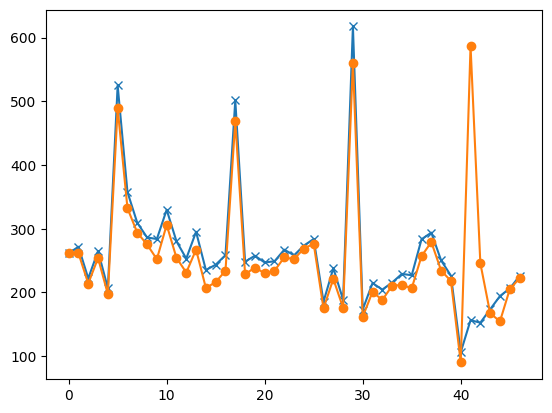

In [61]:
# use lstm


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import xgboost as xgb
import torch

file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='linear')



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


class lstm(torch.nn.Module):
    def __init__(self,in_windows,out_windows, hidden_size, hidden_num_layers):
        super(lstm, self).__init__()
        # 定义LSTM
        self.lstm = torch.nn.LSTM(1, hidden_size, hidden_num_layers)
        # 定义回归层网络，输入的特征维度等于LSTM的输出，输出维度为1
        self.reg = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 25),
            torch.nn.Sigmoid(),
            torch.nn.Linear(25, out_windows),
        )

    def forward(self,x):
        x = x.transpose(-1,-2)
        x = x.view(x.shape[0],x.shape[1],1)
        x,(h,c)= self.lstm(x)
        return self.reg(h[-1])
    

def train_lstm(data,in_windows,out_windows,train_num,epoch_num):
    X = [] 
    y = [] 
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= torch.tensor(X[:train_num]).type(torch.float32),torch.tensor(y[:train_num]).type(torch.float32),torch.tensor(X[train_num:]).type(torch.float32),torch.tensor(y[train_num:],requires_grad=False).type(torch.float32)
    # print("XXXX",X_test.shape)
    model = lstm(in_windows=in_windows,out_windows=out_windows,hidden_size=60,hidden_num_layers=4)
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.01)
    lossfn = torch.nn.MSELoss()
    for epoch_idx in range(epoch_num):
        optimizer.zero_grad()
        out = model(X_train)
        error = lossfn(out,y_train)
        print("epoch_%d:%s"%(epoch_idx,error))
        error.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        test_pred = model(X_test)
        print("lstm r2:",r2_score(y_test,test_pred))
        print("lstm mse:",mean_squared_error(y_test,test_pred))
        print("lstm mae:",mean_absolute_error(y_test,test_pred))
        train_pred = model(X_train)
        res = []
        for i in train_pred.numpy() :
            res.append(i[0])
        for i in test_pred.numpy():
            res.append(i[0])
        return res


def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)


in_window_size,out_window_size = 5,3
train_start = 38
input_data = diff_data[train_start:]
input_data.columns = ['y']
data_predict = train_lstm(input_data.y.values,in_window_size,out_window_size,train_num=40,epoch_num=110)
data_true = input_data[in_window_size:]
if out_window_size!= 1 :
    data_true = data_true[:-out_window_size+1]

# data_true.y.plot()
# data_predict = pd.DataFrame(data_predict)
# data_predict.index = data_true.index
# data_predict[0].plot()
# print(data_predict.shape)


inverse_predict =  inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0]+diff_data[:train_start][0].sum(),data_predict)
inverse_predict = inverse_predict.apply(np.expm1)

inverse_true  = inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0]+diff_data[:train_start][0].sum(),data_true.y)
inverse_true = inverse_true.apply(np.expm1)

print("raw r2:",r2_score(inverse_true[0],inverse_predict[0]))
print("raw mse:",mean_squared_error(inverse_true[0],inverse_predict[0]))
print("raw mae:",mean_absolute_error(inverse_true[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_true[0].plot(marker='o')



In [67]:
inverse_predict[0].to_excel('./temp.xlsx')

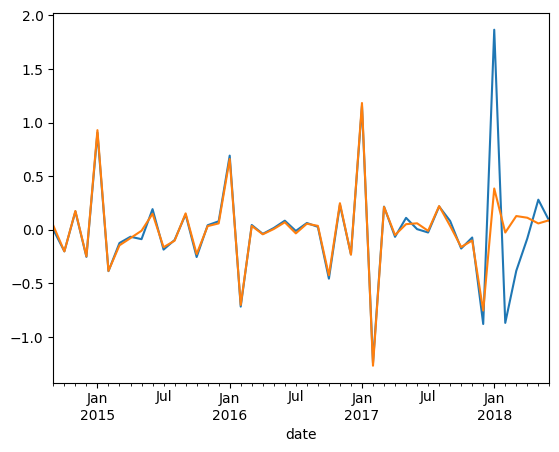

In [66]:
data_true.y.plot()
ndata_predict = pd.DataFrame(data_predict)
ndata_predict.index = data_true.index
ndata_predict[0].plot()
ndata_predict.to_excel('./temp.xlsx')
# print(inverse_true)
# print(inverse_predict.values)

epoch_0:tensor(0.1620, grad_fn=<MseLossBackward0>)
epoch_1:tensor(0.1772, grad_fn=<MseLossBackward0>)
epoch_2:tensor(0.1613, grad_fn=<MseLossBackward0>)
epoch_3:tensor(0.1624, grad_fn=<MseLossBackward0>)
epoch_4:tensor(0.1664, grad_fn=<MseLossBackward0>)
epoch_5:tensor(0.1638, grad_fn=<MseLossBackward0>)
epoch_6:tensor(0.1603, grad_fn=<MseLossBackward0>)
epoch_7:tensor(0.1608, grad_fn=<MseLossBackward0>)
epoch_8:tensor(0.1625, grad_fn=<MseLossBackward0>)
epoch_9:tensor(0.1617, grad_fn=<MseLossBackward0>)
epoch_10:tensor(0.1603, grad_fn=<MseLossBackward0>)
epoch_11:tensor(0.1600, grad_fn=<MseLossBackward0>)
epoch_12:tensor(0.1606, grad_fn=<MseLossBackward0>)
epoch_13:tensor(0.1609, grad_fn=<MseLossBackward0>)
epoch_14:tensor(0.1605, grad_fn=<MseLossBackward0>)
epoch_15:tensor(0.1600, grad_fn=<MseLossBackward0>)
epoch_16:tensor(0.1600, grad_fn=<MseLossBackward0>)
epoch_17:tensor(0.1603, grad_fn=<MseLossBackward0>)
epoch_18:tensor(0.1603, grad_fn=<MseLossBackward0>)
epoch_19:tensor(0.1600

<AxesSubplot:>

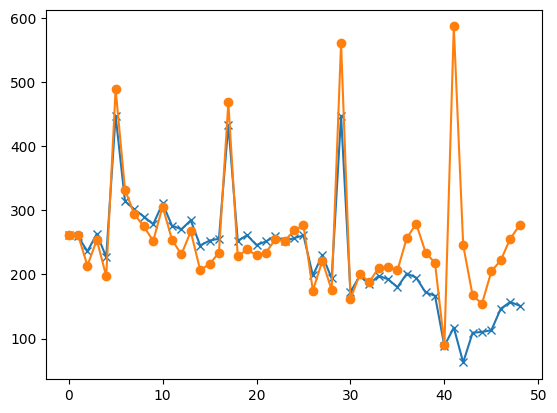

In [107]:

# 集成

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
class lstm(torch.nn.Module):
    def __init__(self,in_windows,out_windows, hidden_size, hidden_num_layers):
        super(lstm, self).__init__()
        # 定义LSTM
        self.lstm = torch.nn.LSTM(1, hidden_size, hidden_num_layers)
        # 定义回归层网络，输入的特征维度等于LSTM的输出，输出维度为1
        self.reg = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 25),
            torch.nn.Sigmoid(),
            torch.nn.Linear(25, out_windows),
        )

    def forward(self,x):
        x = x.transpose(-1,-2)
        x = x.view(x.shape[0],x.shape[1],1)
        x,(h,c)= self.lstm(x)
        return self.reg(h[-1])
    

def train_lstm(data,in_windows,out_windows,train_num,epoch_num):
    X = [] 
    y = [] 
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= torch.tensor(X[:train_num]).type(torch.float32),torch.tensor(y[:train_num]).type(torch.float32),torch.tensor(X[train_num:]).type(torch.float32),torch.tensor(y[train_num:],requires_grad=False).type(torch.float32)
    # print("XXXX",X_test.shape)
    model = lstm(in_windows=in_windows,out_windows=out_windows,hidden_size=60,hidden_num_layers=4)
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.01)
    lossfn = torch.nn.MSELoss()
    for epoch_idx in range(epoch_num):
        optimizer.zero_grad()
        out = model(X_train)
        error = lossfn(out,y_train)
        print("epoch_%d:%s"%(epoch_idx,error))
        error.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        test_pred = model(X_test)
        print("lstm r2:",r2_score(y_test,test_pred))
        mse_val = mean_squared_error(y_test,test_pred)
        print("lstm mse:",mse_val)
        print("lstm mae:",mean_absolute_error(y_test,test_pred))
        train_pred = model(X_train)
        res = []
        for i in train_pred.numpy() :
            res.append(i[0])
        for i in test_pred.numpy():
            res.append(i[0])
        return res,mse_val

def train_xgboost(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = xgb.XGBRegressor(n_estimators=100,learning_rate=0.1,early_stopping_rounds=50)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    print(test_pred)
    print("xgb r2:",r2_score(y_test,test_pred))
    mse_val = mean_squared_error(y_test,test_pred)
    print("xgb mse:",mse_val)
    print("xgb mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res,mse_val

def train_random_forest(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = RandomForestRegressor(n_estimators=30,verbose=True)
    model.fit(X_train,y_train)
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    print(test_pred)
    print("random forest r2:",r2_score(y_test,test_pred))
    mse_val = mean_squared_error(y_test,test_pred)
    print("random forest mse:",mse_val)
    print("random forest mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res,mse_val


def train_gb(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = GradientBoostingRegressor(n_estimators=120,verbose=True)
    model.fit(X_train,y_train)
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    print(test_pred)
    print("gradient boosting r2:",r2_score(y_test,test_pred))
    mse_val = mean_squared_error(y_test,test_pred)
    print("gradient boosting mse:",mse_val)
    print("gradient boosting mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res,mse_val

def train_ab(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = AdaBoostRegressor(n_estimators=240)
    model.fit(X_train,y_train)
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    mse_val = mean_squared_error(y_test,test_pred)
    print("ada boost r2:",r2_score(y_test,test_pred))
    print("ada boost mse:",mse_val)
    print("ada boost mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res,mse_val

def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)
def softmax(x):
    """ softmax function """
    
    
    x -= np.max(x, axis = 0, keepdims = True) #为了稳定地计算softmax概率， 一般会减掉最大的那个元素
    
    x = np.exp(x) / np.sum(np.exp(x), axis = 0, keepdims = True)
    
    return x


file_path = './source_data/A5.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-3]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)




diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

in_window_size,out_window_size = 5,1
train_start = 38
train_num = 40
input_data = diff_data[train_start:]
input_data.columns = ['y']


pred_lstm,err_lstm = train_lstm(input_data.y.values,in_window_size,out_window_size,train_num=train_num,epoch_num=110)
pred_xgb,err_xgb =  train_xgboost(input_data.y.values,in_window_size,out_window_size,train_num=train_num)
pred_rf,err_rf =  train_random_forest(input_data.y.values,in_window_size,out_window_size,train_num=train_num)
pred_ab,err_ab =  train_ab(input_data.y.values,in_window_size,out_window_size,train_num=train_num)
pred_gb,err_gb =   train_gb(input_data.y.values,in_window_size,out_window_size,train_num=train_num)

preds = [pred_lstm,pred_xgb,pred_rf,pred_gb,pred_ab]
errs = [err_lstm,err_xgb,err_rf,err_gb,err_ab]
errs = np.array(errs)
preds = np.array(preds)
confidence = softmax(errs).reshape(-1,1)
data_predict = (confidence * preds).sum(axis=0)

data_true = input_data[in_window_size:]
if out_window_size!= 1 :
    data_true = data_true[:-out_window_size+1]

# # data_true.y.plot()
# # data_predict = pd.DataFrame(data_predict)
# # data_predict.index = data_true.index
# # data_predict[0].plot()
# # print(data_predict.shape)


inverse_predict =  inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0]+diff_data[:train_start][0].sum(),data_predict)
inverse_predict = inverse_predict.apply(np.expm1)

inverse_true  = inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0]+diff_data[:train_start][0].sum(),data_true.y)
inverse_true = inverse_true.apply(np.expm1)

print("raw r2:",r2_score(inverse_true[0],inverse_predict[0]))
print("raw mse:",mean_squared_error(inverse_true[0],inverse_predict[0]))
print("raw mae:",mean_absolute_error(inverse_true[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_true[0].plot(marker='o')



减去行最大值 ：
 [-2 -1  0]


array([0.09003057, 0.24472847, 0.66524096])

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10.])